# Minimal PyTorch Neural Network Training (Forward Pass + Backprop)

This notebook is intentionally tiny. The goal is **understanding the steps**:
1) forward pass → 2) compute loss → 3) backprop (`loss.backward()`) → 4) update weights (`optimizer.step()`)

We’ll fit a simple synthetic regression problem: **y ≈ 2x + 3** (with noise).


## Local setup (macOS Apple Silicon, e.g. MacBook Pro M5) using `uv`

### 1) Install `uv`
```bash
curl -LsSf https://astral.sh/uv/install.sh | sh
```

### 2) Create a project + virtual env + deps
```bash
uv init nn-training-demo
cd nn-training-demo

# Choose a Python version (example: 3.12)
uv python install 3.12
uv python pin 3.12

# Add dependencies (PyTorch + notebook + plotting)
uv add torch torchvision torchaudio jupyterlab matplotlib

# Create/sync the environment
uv sync
```

### 3) Start Jupyter
```bash
uv run jupyter lab
```

> Tip: On Apple Silicon, PyTorch can often use **MPS** (Metal) for acceleration.  
This notebook auto-selects **mps → cuda → cpu** based on availability.


In [2]:
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

print("torch version:", torch.__version__)


torch version: 2.10.0


In [3]:
# Device selection: prefer Apple Metal (MPS) if available
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)


Using device: mps


In [11]:
# --- 1) Create a tiny dataset ---
# y = 2x + 3 + noise
torch.manual_seed(0)

n = 256
X = torch.linspace(-2, 2, n).unsqueeze(1)              # shape: (n, 1)
noise = 0.3 * torch.randn(n, 1)
y = 2.0 * X + 3.0 + noise                               # shape: (n, 1)

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Quick look
print("X shape:", X.shape, "y shape:", y.shape)
print("Sample:", X[0].item(), "->", y[0].item())
print("Sample:", X[1].item(), "->", y[1].item())
print("Sample:", X[2].item(), "->", y[2].item())
print("Sample:", X[3].item(), "->", y[3].item())
print("Sample:", X[4].item(), "->", y[4].item())


X shape: torch.Size([256, 1]) y shape: torch.Size([256, 1])
Sample: -2.0 -> -1.3377519845962524
Sample: -1.984313726425171 -> -1.314335584640503
Sample: -1.9686274528503418 -> -1.0124285221099854
Sample: -1.9529411792755127 -> -1.036046028137207
Sample: -1.9372549057006836 -> -0.619896650314331


In [ ]:


model = nn.Sequential(
    nn.Linear(1, 8), # One input -> 8 signals
    nn.ReLU(), # non linear activation applied to all layers
    nn.Linear(8, 1), # combine the 8 signals into one prediction
).to(device)

print(model)


Sequential(
  (0): Linear(in_features=1, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
)


In [14]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            16
├─ReLU: 1-2                              --
├─Linear: 1-3                            9
Total params: 25
Trainable params: 25
Non-trainable params: 0

In [6]:
# --- 3) Loss function + optimizer ---
# Loss: Mean Squared Error (good for regression)
# Optimizer: SGD (simple and very transparent)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


## Training loop (the exact steps)

For each batch:
1. **Forward pass**: `y_pred = model(X)`
2. **Loss**: `loss = loss_fn(y_pred, y)`
3. **Zero old gradients**: `optimizer.zero_grad()`
4. **Backprop**: `loss.backward()`
5. **Update weights**: `optimizer.step()`


In [ ]:
# --- 4) Train ---
epochs = 50 #We’ll train for 50 epochs (50 full passes over the dataset).
loss_history = [] # We store each epoch’s average loss so we can plot it later.

for epoch in range(1, epochs + 1):
    model.train() # puts the model in training mode

    running = 0.0 #We’ll accumulate total loss across all batches so we can compute an average epoch loss.
    for xb, yb in loader: # loader yeild mini batches 
        xb = xb.to(device) # Batch of inputs to the device
        yb = yb.to(device) # Batch of outputs to the device

        # (1) Forward pass
        y_pred = model(xb)  # Run inputs through the network to get predictions.

        # (2) Compute loss
        loss = loss_fn(y_pred, yb) # Calculate loss - regression here, it’s MSE (average squared error).

        # (3) Clear old gradients
        optimizer.zero_grad() # PyTorch accumulates gradients by default. 

        # (4) Backprop: compute gradients for all parameters
        loss.backward() # Compute gradients for every weight

        # (5) Update parameters
        optimizer.step() # Use the gradients to update weights -> SGD

        running += loss.item() * xb.size(0) # loss.item() is the average loss for this batch. Multiply by xb.size(0) (batch size) to convert it to a sum of loss over examples, so the epoch average is correct even if the last batch is smaller.

    epoch_loss = running / len(dataset)
    loss_history.append(epoch_loss)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | loss={epoch_loss:.4f}")


Epoch 01 | loss=3.9280
Epoch 10 | loss=0.0942
Epoch 20 | loss=0.0999
Epoch 30 | loss=0.0856
Epoch 40 | loss=0.0956
Epoch 50 | loss=0.0850


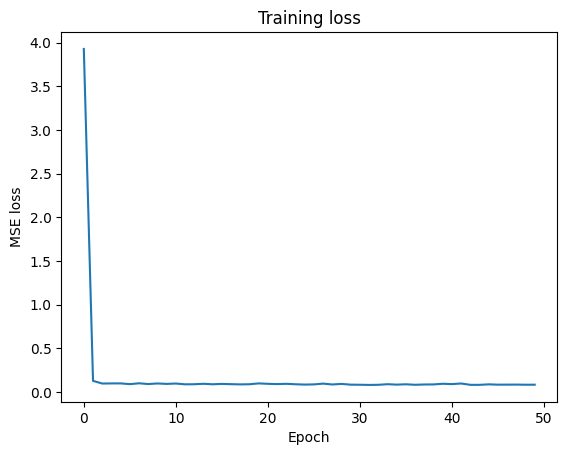

In [8]:
# Plot loss over epochs
plt.figure()
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Training loss")
plt.show()


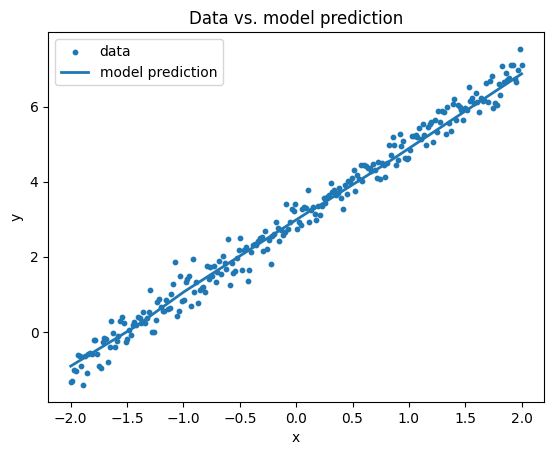

In [9]:
# --- 5) Evaluate / visualize predictions ---
model.eval()

with torch.no_grad():
    Xd = X.to(device)
    y_pred = model(Xd).cpu()

plt.figure()
plt.scatter(X, y, s=10, label="data")
plt.plot(X, y_pred, linewidth=2, label="model prediction")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Data vs. model prediction")
plt.legend()
plt.show()


In [ ]:
# peek at learned weights 
for name, param in model.named_parameters():
    print(name, param.detach().cpu().shape)


0.weight torch.Size([8, 1])
0.bias torch.Size([8])
2.weight torch.Size([1, 8])
2.bias torch.Size([1])
